# Logistic regression classifier

In this notebook, we implement logistic regression classifier described in Section 4.3 of the book PRML. 

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#to make this notebook's output stable across runs
np.random.seed(42)

# 1. Setting 

* Let $N \in \mathbb{N}$ be the number of training data points, 
* $d \in \mathbb{N}$ be the dimension of input, 
* $\mathcal{C} = \left\{ 0, 1, \dots, C-1 \right\}$ be the set of class labels, 
* $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^d$ be the training input data, $y_0, y_1, \dots, y_{N-1} \in \mathcal{C}$ be the training labels, and
$y := (y_0, \dots, y_{N-1})^T \in \mathcal{C}^N$.
* Let $t_n \in \left\{0,1\right\}^{C}$ be the 1-of-$C$ coding of $y_n$, i.e., for $y_n = c$, $t_n$ is a vector with its $c$ th component being 1 and other components being zero. 

# 2. Theory 

## 2.1 Model

We consider the following discriminative model (equation (4.104) in PRML)
$$
\begin{align}
    p(y|x,\theta) = \frac{\exp\left[{\theta^{(y)}}^T \phi(x)\right] }{ \sum_{y'=0}^{C-1} \exp\left[{\theta^{(y')}}^T \phi(x)\right] }
\end{align}
$$
where
* $\phi : \mathbb{R}^d \rightarrow \mathbb{R}^M $, $\phi(x) = (\phi_0(x), \dots, \phi_{M-1}(x))^T$ are basis functions,  
* $\theta^{(y)} \in \mathbb{R}^M$ are weight parameters, and 
* $\theta = \left( {\theta^{(0)}}^T, \dots, {\theta^{(C-1)}}^T  \right)^T \in \mathbb{R}^{CM}$

Later, we use "linear" basis function
$$
\begin{align}
    \phi_j(x) = \begin{cases}
        1 & (j=0)\\
        x^{(j-1)} & (j = 1.\dots, d) 
    \end{cases}
\end{align},
$$
where $x^{(j)}$ represents $j$-th element of $x \in \mathbb{R}^d$


Let $\Phi$ be a $N \times M$ matrix defined by
\begin{equation}
    \Phi = (\Phi_{i,j}), \ \ \Phi_{i,j} = \phi_j(x_i)
\end{equation}

## 2.2 Training 

### 2.2.1 Cost function

In training a logistic classifier, we select the parameter that minimizes the following cost function (See equations (4.107) and (4.108) in PRML) : 
$$
\begin{align}
    J(\theta) :=  - \frac{1}{N} \sum_{n=0}^{N-1} \sum_{c=0}^{C-1} t_{n,c} \log p_{n,c} + \frac{\lambda}{2N} \| \theta \|^2, 
\end{align}
$$
where 
$$
\begin{align}
    p_{n,c} &:= p(c|x_n,\theta) = \frac{\exp\left[{\theta^{(c)}}^T \phi(x_n)\right] }{ \sum_{c'=0}^{C-1} \exp\left[ {\theta^{(c')}}^T \phi(x_n)  \right]}  \\
    t_{n,c} &:= \delta_{y_n, c}
\end{align}
$$
the first term is negative log likelihood, and the second term is a $l^2$ regularization term.

### 2.2.2 Gradient

To perform the minimization, we need the gradient of the cost function, which is given by (See equation (4.109) in PRML)
$$
\begin{align}
    \frac{\partial J}{\partial \theta^{(c)}_{j}} = 
        \frac{1}{N} \sum_{n=0}^{N-1} ( p_{n,c} -  t_{n,c}) \phi_j(x_n) + \frac{\lambda}{N} \theta^{(c)}_{j}
\end{align}
$$

# 3. From math to code

## 3.1 Matrix representation

Here we express cost function and its gradient using a matrix notation. 
The following matrix will be used:
* $\Phi$ or `Phi` : `(N, M)` array, where `Phi[n, m]` = $\phi_m(x_n)$
* $\Theta$ or `Theta` : `(C, M)` array, where `Theta[c, j]` = $\theta^{(c)}_{j}$
* $T$ or `T` : `(N,C)` array, where `T[n, c]` = $t_{n, c}$
* $P$ or `P` : `(N, C)` array, where `P[n, c]` = $p_{n, c}$

Note that $P$ can be expressed by $\Phi$ and $\Theta$ as 

$$
\begin{align}
    P_{n,c} &= \frac{\exp\left[\sum_{j=0}^{M-1} \theta^{(c)}_{j} \phi_{j}(x_n)\right] }{ \sum_{c'=0}^{C-1} \exp\left[ \sum_{j=0}^{M-1} \theta^{(c')}_{j} \phi_{j}(x_n)  \right]} \\
    &= \frac{ \exp \left[ \left( \Phi \Theta^T \right)_{n, c'} \right]  }{ \sum_{c'=0}^{C-1} \exp\left[ \left( \Phi \Theta^T \right)_{n, c'} \right] }
\end{align}
$$

In [2]:
def genPhimat(X):
    '''
    This function generates the design matrix Phi from X, the input data
        
    Parameters
    ----------
    X : 2-D numpy array
        (N,d) numpy array, with X[n, i] = i-th element of x_n
            
    Returns
    ----------
    Phi : 2-D numpy array
        The design matrix
    '''
    N = len(X)
    if len(np.shape(X)) == 1:
        d = 1
    else:
        d = np.shape(X)[1]
    Phi = np.zeros((N,d+1))
    Phi[:,0] = np.ones(N)
    Phi[:,1:] = np.reshape(X, (N,d))
    return Phi

def genTmat(y, C):
    '''
    This function generates the matrix T from the training label y and the number of classes C
    
    Parameters
    ----------
    y : 1-D numpy array
        The elements of y should be integers in [0, C-1]
    C : int
        The number of classes
        
    Returns
    ----------
    T : (len(y), C) numpy array
        T[n, c] = 1 if y[n] == c else 0
    '''
    N = len(y)
    T = np.zeros((N, C))
    for c in range(C):
        T[:, c] = (y == c)
    return T

def genPmat(Theta, Phi):
    '''
    This function generates the matrix P from the weight Theta and the design matrix Phi
    
    Parameters
    ----------
    Theta : 2-D numpy array
        Matrix representing the weight parameter
    Phi : 2-D numpy array
        The design matrix
        
    Returns
    ----------
    P : 2-D numpy array
    '''
    P = np.exp( Phi @ (Theta.T) )
    P = P/np.reshape( np.sum(P, axis= 1), (len(Phi),1)  ) 
    return P

## 3.2 Loss function and its gradient

With these definitions, we have
$$
\begin{align}
    J(\Theta) 
        &= - \frac{1}{N} \sum_{n=0}^{N-1} \sum_{c=0}^{C-1} t_{n,c} \log p_{n,c} + \frac{\lambda}{2N} \| \theta \|^2  \\
        &= -\frac{1}{N} sum(T \ast \log P) + \frac{\lambda}{2N} \| \Theta \|_{2}^{2}
\end{align}
$$
where $\log$ means elementwise log, $\ast$ means elementwise product, and, $sum$ means summing up all elements of a matrix. 
If we regard $\frac{\partial J(\Theta)}{\partial \Theta}$ as a matrix, 
$$
\begin{align}
    \frac{\partial J(\Theta)}{\partial \Theta}
    &= \left(  \frac{1}{N} \sum_{n=0}^{N-1} ( p_{n,c} -  t_{n,c}) \phi_j(x_n) + \frac{\lambda}{N} \theta^{(c)}_{j} \right)_{c,j} \\
    &= \frac{1}{N} (P-T)^T \Phi + \frac{\lambda}{N} \Theta
\end{align}
$$

In [3]:
class LogisticClf:
    def __init__(self, C, lam):
        self.C = C  # the number of labels
        self.lam = lam #regularization parameter
        self.Theta = None
        
    def JandGradJ(self, thtvec, Phi, T):
        '''
        This method calculate the loss function and its gradient
        
        Parameters
        ----------
        thtvec : 1-D numpy array 
            (M*C,) array, which represents the weight parameter Theta, in flattened form
        Phi : 2-D numpy array
            (N, M) array, design matrix
        T : 2-D numpy array
            (N, C) array, where T[n, c] = 1 if y[n] == c else 0
        
        Returns
        ----------
        J : float
            The value of loss function
        gradJvec : 1-D numpy array
            The gradient of the loss function with respect to the weight parameter Theta, in flattened form
        
        '''
        N, M = np.shape(Phi)
        Theta = np.reshape(thtvec, (self.C, M))
        P = genPmat(Theta, Phi)
        J = -1.0/N*np.sum(T*np.log(P)) + self.lam/(2.0*N)*np.linalg.norm(thtvec)**2
        gradJmat = 1.0/N*((P - T).T) @ Phi + self.lam/N*Theta
        gradJvec = np.reshape(gradJmat, len(thtvec))
        return J, gradJvec
    
    def fit(self, X, y):
        '''
        Parameters
        ----------
        X : 1-D or 2-D numpy array
            (N,) or (N, d) array, representing the training input data
        y : 1-D numpy arra
            (N,) array, representing training labels
        '''
        Phi = genPhimat(X)
        T = genTmat(y, self.C)
        N, M = np.shape(Phi)
        
        tht0 = np.ones(M*self.C)
        result = minimize(lambda x : self.JandGradJ(x, Phi, T), x0=tht0, jac=True)
        self.Theta = np.reshape(result['x'], (self.C, M))
        
    def predict_proba(self, X):
        '''
        Parameters
        ----------
        X : 1-D or 2-D numpy array
            (N,) or (N, d) array, representing the training input data
        Returns
        ----------
        proba : 2-D numpy arra
            (len(X), self.C) array, where proba[n, c] represents the probability that the n-th instance belongs to c-th class
        '''
        return genPmat(self.Theta, genPhimat(X))
        
    def predict(self, X):
        '''
        Parameters
        ----------
        X : 1-D or 2-D numpy array
            (N,) or (N, d) array, representing the training input data
        Returns
        ----------
        classes : 1-D numpy arra
            (len(X), ) array, where classes[n] represents the predicted class to which the n-th instance belongs
        '''
        tmp = self.predict_proba(X)
        return np.argmax(tmp, axis=1 )

# 4. Experiment

In [4]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## 4.1 Toy data

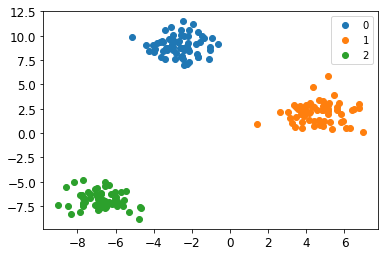

In [5]:
X, y = datasets.make_blobs(n_samples=200, n_features=2, centers=3)
for c in range(3):
    plt.plot(X[:,0][y==c], X[:,1][y==c], 'o', label=f'{c}')
plt.legend()
plt.show()

In [16]:
xx = np.linspace(np.min(X[:,0]), np.max(X[:,0]),101)
yy = np.linspace(np.min(X[:,1]), np.max(X[:,1]),100)
Xtest = np.array([[x,y] for x in xx  for y in yy])
xxx,yyy = np.meshgrid(xx, yy)

def plot_result_blob(clf, C):
    for c in range(C):
        plt.plot(X[:,0][y==c], X[:,1][y==c],"o",label=f"{c}")
    plt.legend()
    pred_val = clf.predict(Xtest)
    pred_val_2D = np.reshape(pred_val, (len(xx), len(yy))).T
    plt.pcolormesh(xxx, yyy, pred_val_2D)
    plt.colorbar()
    plt.show()

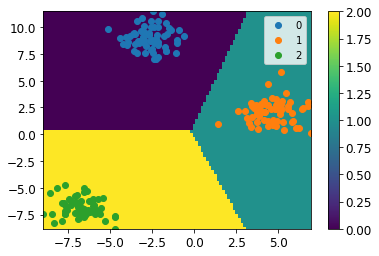

In [17]:
clf = LogisticClf(C = 3, lam = 1.0)
clf.fit(X, y)
plot_result_blob(clf, 3)

We can see that data are completely separated, and the decision boundaries are straight, because we employed 'linear' basis functions.

## 4.2 Hand-written digits

In [8]:
digits = datasets.load_digits()
dat_train, dat_test, label_train, label_test = train_test_split(digits.data, digits.target, test_size=0.25)

print(f"Training data : {len(dat_train)}")
print(f"Test data : {len(dat_test)}")

Training data : 1347
Test data : 450


In [9]:
def show_result_digit(clf):
    label_test_pred = clf.predict(dat_test)
    print(f"train accuracy score: {accuracy_score(label_train, clf.predict(dat_train))}")
    print(f"test accuracy score: {accuracy_score(label_test, label_test_pred)}")

Below, we can see that, as we increase the regularization parameter, the training score gets worse, while the test score gets better, which is consistent with our intuition that large regularization means large bias and small variance.

In [15]:
lams = [0.1, 1.0, 10.0]

for lam in lams:
    clf = LogisticClf(C=10, lam=lam)
    clf.fit(dat_train, label_train)
    print(f"lambda = {lam}")
    show_result_digit(clf)

lambda = 0.1
train accuracy score: 1.0
test accuracy score: 0.9533333333333334
lambda = 1.0
train accuracy score: 1.0
test accuracy score: 0.9577777777777777
lambda = 10.0
train accuracy score: 0.9992576095025983
test accuracy score: 0.9666666666666667


# Appendix scikit-learn

In this appendix, we demonstrate how we can use the scikit-learn library to perform logistic regression.

For detail, see official documentations.

In [18]:
from sklearn.linear_model import LogisticRegression

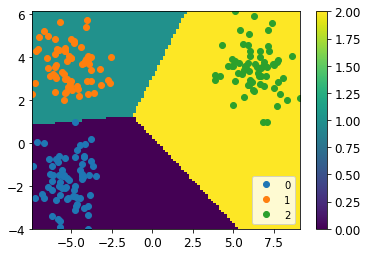

In [22]:
clf = LogisticRegression()
clf.fit(X, y)
plot_result_blob(clf, 3)

In [26]:
clf = LogisticRegression()
clf.fit(dat_train, label_train)
show_result_digit(clf)

train accuracy score: 0.9992576095025983
test accuracy score: 0.9533333333333334
